To illustrate the power of denoising the system by averaging, the simple analysis of the filtering will be considered for a time pulse.  In beginning this process, a time window must be selected and its Fourier resolution decided.

In order to be more effective in plotting our spectral results, the Fourier components in the standard shifted frame (```k```) and its unshifted counterpart (```ks```) are both produced.  Further, the noise strength of the system is selected.

In [1]:
import numpy as np
from numpy.fft import fft, fftshift, ifft

L = 30                          # time slot
n = np.power(2,9)               # number Fourier modes
t = np.linspace(-L, L, n+1)
t = t[:-1]                      # time domain
k = (2*np.pi/(2*L))*np.concatenate((np.arange(0,n/2), np.arange(-n/2,0)))  # frequency domain
ks = fftshift(k)
noise = 10

Next, the total number of data frames (i.e., realizations of the incoming signal stream) is considered.  The word "realizations" is used here to help underscore the fact that for each data frame, a new realization of the white noise is produced.  Here, one, two, five, and one hundred realizations are considered.

With one realization, it is difficult to determine if theere is a true signal, or if the entire spectrum is noise.  Already after two realizations, the center frequency structure starts to appear.  Five realizations has a high degree of discrimination between the noise and signal, and 100 realization is almost exactly converged to the ideal, noise-free signal.  

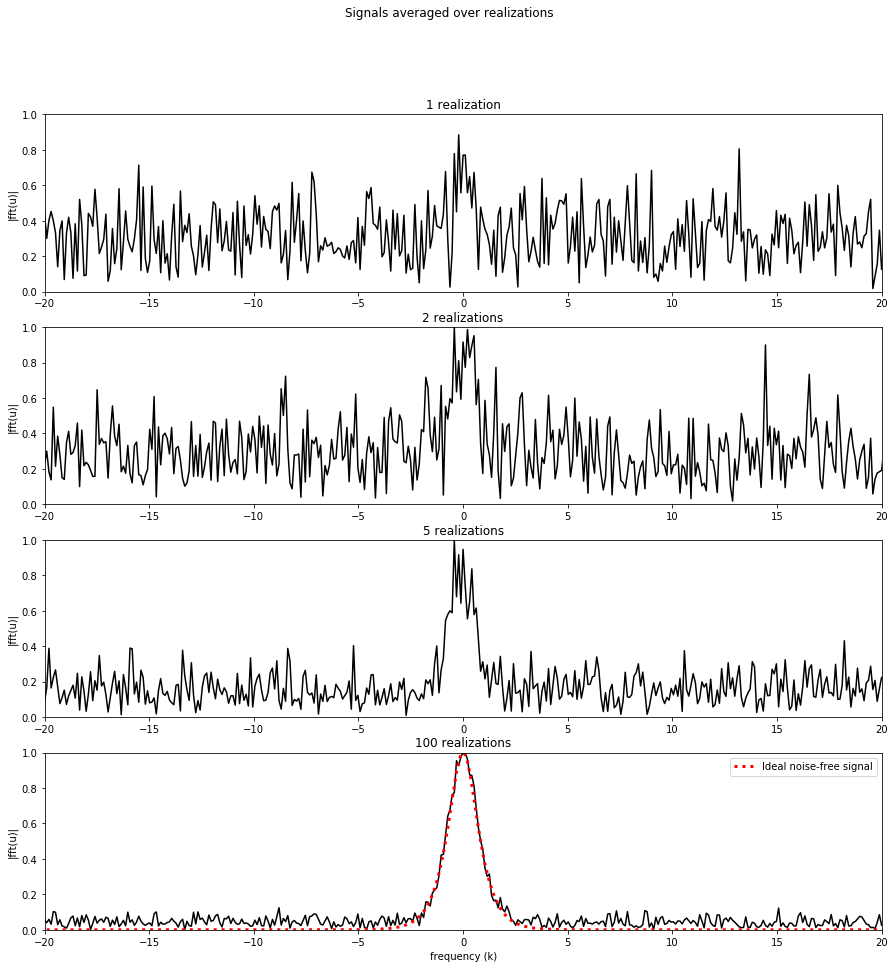

In [2]:
from numpy.random import randn
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]

u = 1/np.cosh(t)                # the function to be analyzed
ut = fft(u)                     # the Fourier transform of the function

realize = [1, 2, 5, 100]

fig=plt.figure()
fig.suptitle('Signals averaged over realizations')

for r in np.arange(0,len(realize)):
    ii = realize[r]
    utn = np.zeros((ii,n), dtype=complex)      # store the transform for each realization on a separate row
    un = np.zeros((ii,n), dtype=complex)       # store the inverse transform of each realization on a separate row
    dat = np.zeros((ii,n), dtype=complex)      # initialize the data
    for i in np.arange(0,ii):
        utn[i,:] = ut + noise*(randn(1,n) + 1j*randn(1,n))    # add noise to the transform
        dat[i,:] = np.abs(fftshift(utn[i,:]))/np.max(np.abs(utn[i,:]))   # store the normalized transform for later
        un[i,:] = ifft(utn[i,:]) 
    ave = np.abs(fftshift(utn.sum(0)))/ii  # average out over all the realizations
    ax = fig.add_subplot(411+r)
    ax.plot(ks, ave/ave.max(),'k')
    ax.set_xlim(-20, 20); ax.set_ylim(0, 1)
    ax.set_title(str(ii)+' realization'+('s' if ii>1 else ''))
    ax.set_ylabel('|fft(u)|')

# plot ideal signal on last plot
il = ax.plot(ks, abs(fftshift(ut))/max(abs(ut)),'r:', linewidth=3)
ax.set_xlabel('frequency (k)')
ax.legend(il, ['Ideal noise-free signal'])

As expected, the noise in the averaging process is eliminated since its mean is zero.  To view a few of the data realizations used in computing the averaging, the first eight signals used to compute the average for 100 realizations are shown below.  

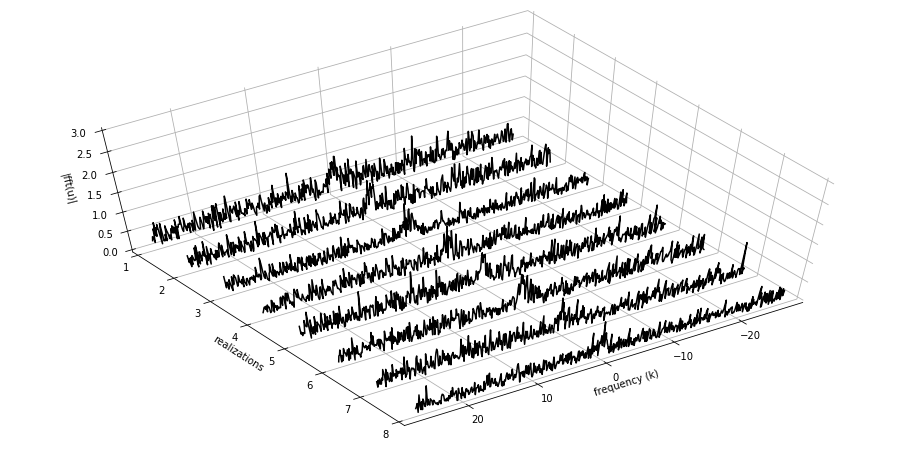

In [3]:
from mpl_toolkits.mplot3d import Axes3D

mr = 8

fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.gca(projection='3d')

for r in np.arange(0,mr):
    ax.plot(ks, np.abs(dat[r,:]), r+1, 'k-', zdir='y')
    
ax.set_xlabel('frequency (k)')
ax.set_xlim3d(-28, 28)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_ylabel('realizations')
ax.set_ylim3d(1, mr)
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_zlabel('|fft(u)|')
ax.set_zlim3d(0,3)
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(azim=55,elev=60)

The averaging process can ultimately extract a clean spectral signature.  As a consequence however, you completely lose the time domain dynamics.  In other words, one could perform an inverse transform on the cleaned-up spectrum but this would only give the averaged time domain signal, not how it actually evolved over time.  

To consider the problem more concretely, consider the code below, which generates a time-varying signal.  If this were a radar platform, the movement of the signal would represent an aircraft moving in  time.  The spectrum, however, remains fixed at the transmitted signal frequency.  Thus it is clear even at this point that averaging over the frequency realizations produces a clean, localized signature in the frequency domain, whereas averaging over the time domain only smears out the evolving time domain pulse.

Text(0.5, 0.92, 'Ideal frequency domain pulse with uniform spectral signal')

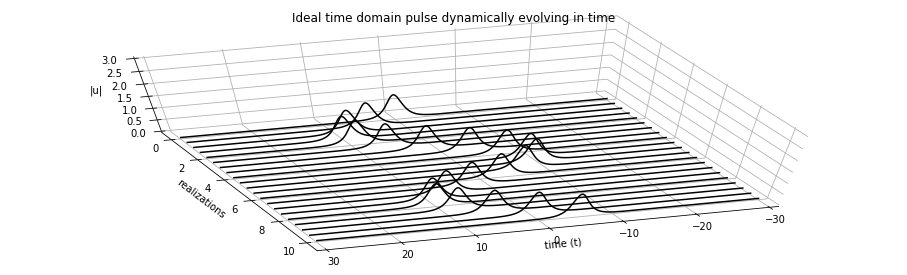

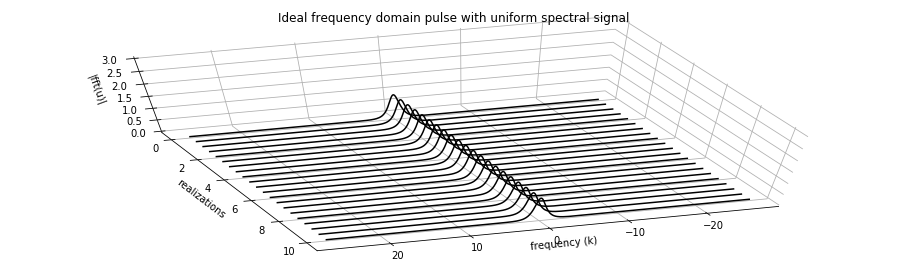

In [4]:
slice = np.arange(0,10.1,0.5)             # time slices/realizations
[T, S] = np.meshgrid(t, slice)
[K, S] = np.meshgrid(k, slice)
freq = 0                                  # center frequency (k) of signal
U = 1/np.cosh(T-10*np.sin(S))*np.exp(1j*freq*T)   #  a signal varying in space/time but not in frequency

Kp = fftshift(K,1)                                            # shift within realization (on the 1 axis)
Ut = fft(U)                                                   # clean signal in frequency domain
Utp = fftshift(Ut,1)                                          # shifted clean signal in freq domain

# plot evolving signal in time domain
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.gca(projection='3d')

for i in np.arange(0,len(slice)):                              # plot realizations one by one so they look right
    ax.plot(T[i,:], np.abs(U[i,:]), slice[i], 'k-', zdir='y')
    
ax.set_xlabel('time (t)')
ax.set_xlim3d(-30, 30)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_ylabel('realizations')
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_zlabel('|u|')
ax.set_zlim3d(0,3)
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(azim=70,elev=60)
ax.set_title('Ideal time domain pulse dynamically evolving in time')
    
# plot normalized, clean spectral signature in freq domain
fig2 = plt.figure(figsize=plt.figaspect(0.3))
ax2 = fig2.gca(projection='3d')

for i in np.arange(0,len(slice)):                              # plot realizations one by one so they look right
    ax2.plot(Kp[i,:], np.abs(Utp[i,:])/np.abs(Utp[i,:]).max(), slice[i], 'k-', zdir='y')

ax2.set_xlabel('frequency (k)')
ax2.set_xlim3d(-28, 28)
ax2.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.set_ylabel('realizations')
ax2.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.set_zlabel('|fft(u)|')
ax2.set_zlim3d(0,3)
ax2.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.view_init(azim=70,elev=60)
ax2.set_title('Ideal frequency domain pulse with uniform spectral signal')

Here, the ideal pulse evolution from above is inundated with white noise.  The noise is added to each realization (i.e., data measurement) with the same strength as used in the earlier examples in this notebook.  The associated plots below show a more physically realistic depiction of the time domain and frequency spectrum as a function of the number of realizations.

Text(0.5, 0.92, 'Noise-inundated frequency domain pulse with uniform spectral signal')

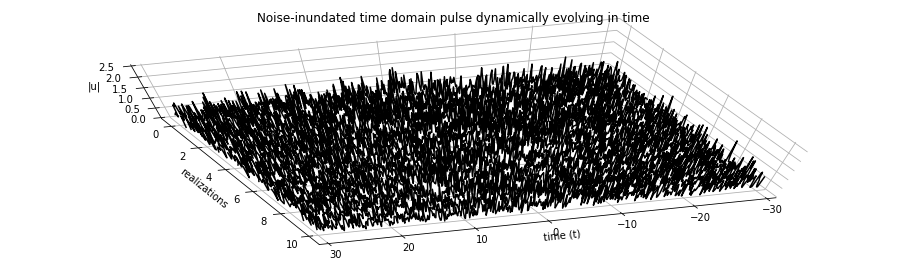

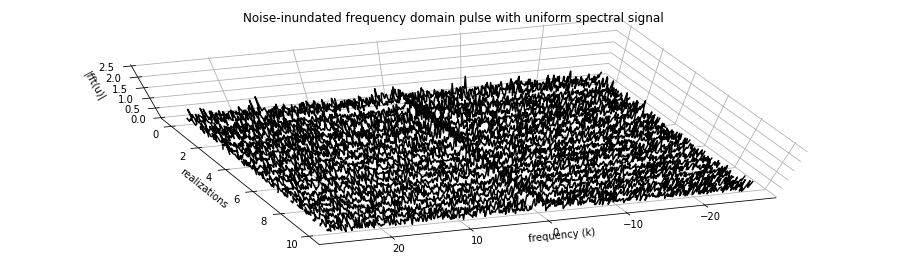

In [5]:
Utn = Ut + noise*(randn(*Ut.shape) + 1j*randn(*Ut.shape))     # noisy signal in freq domain
Un = ifft(Utn)                                                # noisy signal in time domain
Utn_rnorm = np.abs(Utn).max(1).reshape(len(slice),1)          # max abs value per realization
Utnp = fftshift(Utn,1)/Utn_rnorm                              # noisy, shifted, normalized signal in freq domain

# plot noisy signal in time domain
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.gca(projection='3d')

for i in np.arange(0,len(slice)):                              # plot realizations one by one so they look right
    ax.plot(T[i,:], np.abs(Un[i,:]), slice[i], 'k-', zdir='y')
    
ax.set_xlabel('time (t)')
ax.set_xlim3d(-30, 30)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_ylabel('realizations')
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.set_zlabel('|u|')
ax.set_zlim3d(0,2.5)
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.view_init(azim=70,elev=70)
ax.set_title('Noise-inundated time domain pulse dynamically evolving in time')

# plot normalized, clean spectral signature in freq domain
fig2 = plt.figure(figsize=plt.figaspect(0.3))
ax2 = fig2.gca(projection='3d')

for i in np.arange(0,len(slice)):                              # plot realizations one by one so they look right
    ax2.plot(Kp[i,:], np.abs(Utnp[i,:]), slice[i], 'k-', zdir='y')

ax2.set_xlabel('frequency (k)')
ax2.set_xlim3d(-28, 28)
ax2.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.set_ylabel('realizations')
ax2.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.set_zlabel('|fft(u)|')
ax2.set_zlim3d(0,2.5)
ax2.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax2.view_init(azim=70,elev=70)
ax2.set_title('Noise-inundated frequency domain pulse with uniform spectral signal')

The goal is to extract the meaningful data buried within the noise.  The obvious question arises about how to clean up the signal and whether something meaningful can be extracted from the data or not. After all, there are only 21 data slices to work with.  

Here, data is averaged over all realizations in both the time and frequency domains.  The results from the averaging process for a nonstationary signal are shown.  The top graph shows that averaging over the time domain for a moving signal produces no discernible signal.  However, averaging over the frequency domain produces a clear signature at the center frequency of interest. 

Text(0.5, 1.0, 'Noisy frequency domain averaged over all measurements')

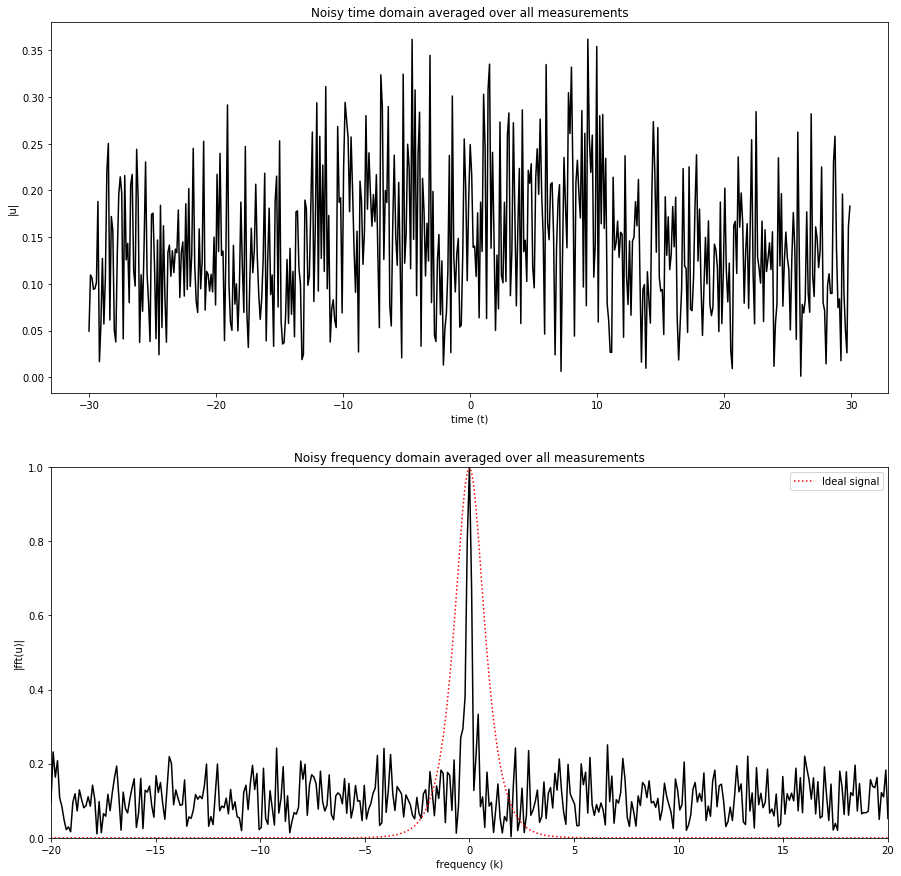

In [6]:
# sum column-wise, then average over the number of slices
Uavg = Un.sum(0)/len(slice)                  # averaged noisy time domain signal 
Utavg = fftshift(Utn.sum(0))/len(slice)      # averaged noisy freq domain signal

fig, (axt, axf) = plt.subplots(2, 1)

axt.plot(t, np.abs(Uavg), 'k')
axt.set_xlabel('time (t)'); axt.set_ylabel('|u|')
axt.set_title('Noisy time domain averaged over all measurements')

axf.plot(ks, np.abs(Utavg)/np.abs(Utavg).max(), 'k')
axf.plot(ks, np.abs(fftshift(Ut[0,:]))/np.abs(Ut[0,:]).max(), 'r:', label='Ideal signal')
axf.set_xlim(-20, 20); axf.set_ylim(0,1)
axf.set_xlabel('frequency (k)'); axf.set_ylabel('|fft(u)|')
axf.legend()
axf.set_title('Noisy frequency domain averaged over all measurements')